In [1]:
!pwd 


/uufs/chpc.utah.edu/common/home/u1215181/icepack/notebooks/real_case_practise


In [2]:
import firedrake
import icepack

### Read geojson file to get the glacier outlines
Load the geojson file with "r" read only \
List the geojson coordinates with geojson.utils.coords() 

Example:

import geojson \
outline_filename = "mergedfile.geojson"\
with open(outline_filename, "r") as outline_file:\
    outline = geojson.load(outline_file)\
Coord = list(geojson.utils.coords(outline))

In [3]:
import json
import geojson
import pyproj
import numpy as np

outline_filename = "mergedfile.geojson"
with open(outline_filename,'r') as geojson_file:
    geojson_data = json.load(geojson_file)    
#geojson_data

### Convert the lat/lon coordinate to UTM, transform degree to meter
Example:
import pyproj\
lat_lon = pyproj.CRS(4326)\
utm8 = pyproj.CRS(32608)\
transformer = pyproj.Transformer.from_crs(lat_lon, utm8)\
print(transformer.transform(coords[0][0], coords[0][1]))\
print(transformer.transform(coords[0][1], coords[0][0]))

In [4]:
#geojson_data

In [5]:
# Create a pyproj transformer for the conversion
# WGS 84 (EPSG:4326) is the coordinate system for latitude and longitude
# UTM zone 8N (EPSG:32608) is a common UTM projection for the western United States
wgs84 = pyproj.CRS("EPSG:4326")
utm8 = pyproj.CRS('EPSG:32608')
transformer = pyproj.Transformer.from_crs(wgs84, utm8)

# Function to convert a single point to UTM
def convert_to_utm(point):
    longitude, latitude = point
    utm_easting, utm_northing = transformer.transform(latitude, longitude)
    return utm_easting, utm_northing

# Function to convert a list of points to UTM
def convert_polygon_to_utm(polygon):
    utm_polygon = []
    for ring in polygon:
        utm_ring = [convert_to_utm(point) for point in ring]
        utm_polygon.append(utm_ring)
    return utm_polygon

# Extract the coordinates from the GeoJSON data
# Access the feature key in the GeoJSON data
features = geojson_data.get('features',[])
# Iterate through the features
for feature in features:
    # get the 'geometry' key to eatch feeatures
    geometry = feature.get('geometry',{})
    # access the 'coordinate' key in the geometry
    coordinates = geometry.get('coordinates',[])
#      print(coordinates)
    utm_coordinates = convert_polygon_to_utm(coordinates)
#     print(utm_coordinates)

In [6]:
print(geojson_data["crs"]["properties"]["name"])

urn:ogc:def:crs:OGC:1.3:CRS84


In [7]:
### Create the outline plot
import numpy as np
δ = 50e3
coords = np.array(list(geojson.utils.coords(geojson_data)))
xmin, xmax = coords[:, 0].min() - δ, coords[:, 0].max() + δ
ymin, ymax = coords[:, 1].min() - δ, coords[:, 1].max() + δ

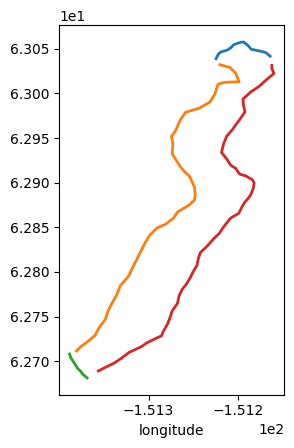

In [8]:
import icepack.plot

fig, axes = icepack.plot.subplots()

for feature in geojson_data["features"]:
    for line_string in feature["geometry"]["coordinates"]:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel("longitude");

Initial mesh generation.

In [9]:
from meshpy import triangle

In [10]:
geometry = icepack.meshing.collection_to_triangle(geojson_data)

In [11]:
triangle_mesh = triangle.build(geometry, max_volume=4e-5)

In [12]:
mesh = icepack.meshing.triangle_to_firedrake(triangle_mesh)

In [13]:
Q = firedrake.FunctionSpace(mesh, "CG", 2)
V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

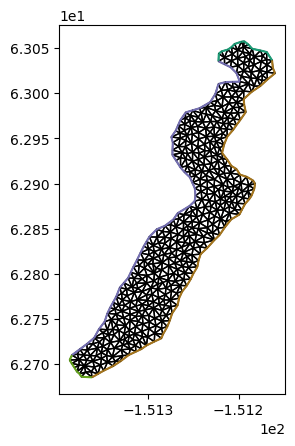

In [14]:
fig, axes = icepack.plot.subplots()
firedrake.triplot(mesh, axes=axes)
#axes.legend()

In [15]:
S = firedrake.FunctionSpace(mesh, "DG", 0)
areas = firedrake.project(firedrake.CellVolume(mesh), S)

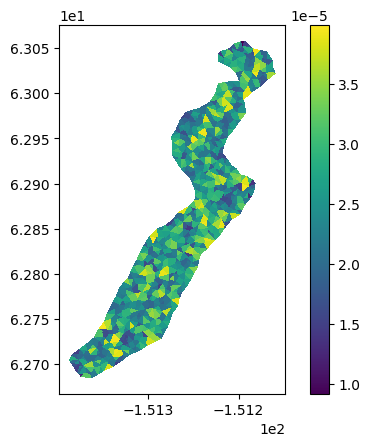

In [16]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(areas, axes=axes)
fig.colorbar(colors);

In [17]:
min_coord = min(min(coordinates))
max_coord = max(max(coordinates))
print(f"coordinate info: min={min_coord}, max={max_coord}")
min_lat = min_coord[:1], 
min_lon = min_coord[1:],
print(f"min_lat={min_lat}, min_lon={min_lon}")
max_lat = max_coord[:1], 
max_lon = max_coord[1:],
print(f"max_lat={max_lat}, max_lon={max_lon}")

coordinate info: min=[-151.35621798276324, 62.68905108030866], max=[-151.15950564197698, 63.02230720095851]
min_lat=([-151.35621798276324],), min_lon=([62.68905108030866],)
max_lat=([-151.15950564197698],), max_lon=([63.02230720095851],)


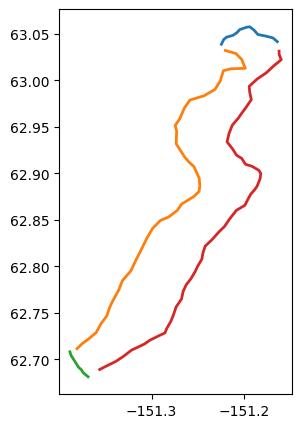

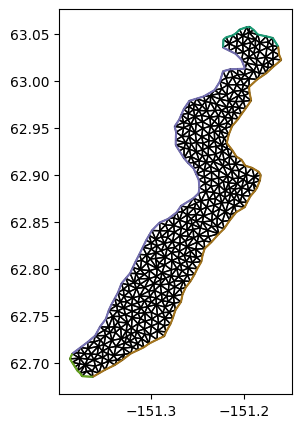

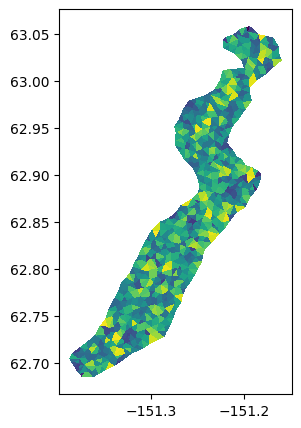

In [38]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#num_frames = 10

fig1, ax1 = plt.subplots(figsize=(3,5))

for feature in geojson_data["features"]:
        for line_string in feature["geometry"]["coordinates"]:
            xs = np.array(line_string)
            line, = ax1.plot(xs[:, 0], xs[:, 1], linewidth=2)


def ani_pnl_1(frame):
    # clear previous plots
    ax1.clear()
        
    for feature in geojson_data["features"]:
        for line_string in feature["geometry"]["coordinates"]:
            xs = np.array(line_string)
            line, = ax1.plot(xs[:, 0], xs[:, 1], linewidth=2)
    return line,

# ani1 = FuncAnimation(fig1, ani_pnl_1, frames=25, repeat=False)
plt.savefig(f'images/01', dpi=100, facecolor='white')

# second figure
fig2, ax2 = plt.subplots(figsize=(3,5))
mesh_plot = firedrake.triplot(mesh, axes=ax2)
def ani_pnl_2(frame):
    ax2.clear()
    mesh_plot = firedrake.triplot(mesh, axes=ax2)
    return mesh_plot,

#ani2 = FuncAnimation(fig2, ani_pnl_2, frames=50, repeat=False)
plt.savefig(f'images/02', dpi=100, facecolor='white')

# third figure
fig3, ax3 = plt.subplots(figsize=(3,5))
colors = firedrake.tripcolor(areas, axes=ax3)
def ani_pnl_3(frame):
    ax3.clear()
    colors = firedrake.tripcolor(areas, axes=ax3)
    return colors,

# ani3 = FuncAnimation(fig3, ani_pnl_3, frames=100, repeat=False)
plt.savefig(f'images/03', dpi=100, facecolor='white')

# ani3.save('animation.mp4', dpi=100)
# HTML(ani3.to_html5_video())
plt.show()

Mesh refinement.

In [40]:
# !convert -delay 5 images
# !pip install pillow imageio
import os
import imageio
image_folder = 'images/'
png_files = [file for file in os.listdir(image_folder) if file.endswith('.png')]
png_files.sort()
image_paths = []

for png_file in png_files:
    image_paths.append(os.path.join(image_folder, png_file))
    
with imageio.get_writer('meshing_alpine_glacier.gif', mode='I', duration=1, loop=30, fps=2) as writer:
    for image_path in image_paths:
        image = imageio.imread(image_path)
        writer.append_data(image)


/scratch/local/u1215181/363185/ipykernel_210329/1664663457.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


In [20]:
x = firedrake.SpatialCoordinate(mesh)
expr = firedrake.conditional(
    x[1] <= 62.9,
    areas / 2,
    areas
)
desired_areas = firedrake.project(expr, S)

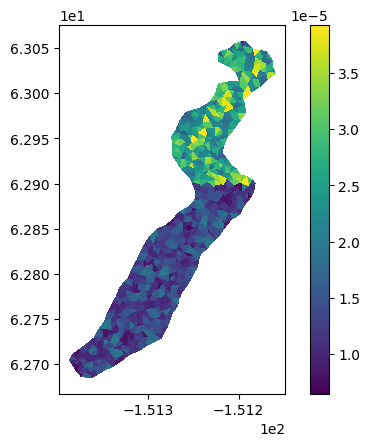

In [21]:
fig, axes = icepack.plot.subplots()
colors = firedrake.tripcolor(desired_areas, axes=axes)
fig.colorbar(colors);

In [22]:
triangle_mesh.element_volumes.setup()
for index, area in enumerate(desired_areas.dat.data_ro):
    triangle_mesh.element_volumes[index] = area

In [23]:
refined_triangle_mesh = triangle.refine(triangle_mesh)

In [24]:
fine_mesh = icepack.meshing.triangle_to_firedrake(refined_triangle_mesh)

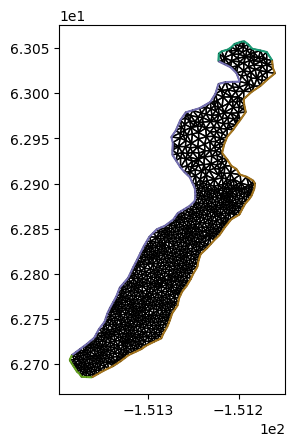

In [25]:
fig, axes = icepack.plot.subplots()
firedrake.triplot(fine_mesh, axes=axes);